<a href="https://colab.research.google.com/github/iwannamakeid/Multivariate-statistics/blob/main/%EC%99%95%EC%A7%80%EC%98%81_%EA%B3%BC%EC%A0%9C_4(%EC%A3%BC%EC%84%9D%ED%8F%AC%ED%95%A8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redefining the model to be w2 * t_u ** 2 + w1 * t_u + b
## w* t_u +b 모델과 w2 * t_u ** 2 + w1 * t_u + b 모델 비교하기
### 변수 설명

1. t_c: target data
2. t_u: input data
3. t_un: t_u의 정규화
4. params: 매개변수, input 각 값에 적용되는 weight값과 bias 값을 담고 있다.
#### 각 함수별로 사용되는 변수들은 따로 설명하겠다.

In [ ]:
#set data and tools

%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems = 2, linewidth = 75)

In [ ]:
#input datum

t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0,
                    8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9,
                    33.9, 21.8, 48.4, 60.4, 68.4])
t_un = 0.1 * t_u #입력 데이터 정규화

In [ ]:
# inner functions of 1-layer perceptron

# basic linear model
def model1(t_u, w, b):
    return w*t_u + b

# the given non linear model
# add a new input and weights to model1
def model2(t_u, w, w2, b):
    t_u2 = t_u**2
    return w2* t_u2 + w * t_u + b 

#loss functionof Mean Square Error
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean() #return the Target - Output(t_p)

#spliting data into test set and validation set following the ratio of 8:2 
def split_data(t_u):
    n_samples = t_u.shape[0] #number of input samples
    n_val = int(0.2 * n_samples) # set the propertation of validation set

    shuffled_indices = torch.randperm(n_samples) #shuffle the order of data
    train_indices = shuffled_indices[:-n_val]
    val_indices = shuffled_indices[-n_val:]

    return train_indices, val_indices

#forward propagation that returns loss value by using model and train set
# t_u: input data, t_c: target data, model: model name,
# is_train: check the given data is train data
def calc_forward(t_u, t_c,model, is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss

In [ ]:
# training loop for learning
# n_epochs: number of epoch
# optimizer: choosen optimizer
# params: parameters including w, b
# model: choosen model for learning
# train_t~, val_t: using each train and valication sets for learning 
def training_loop(n_epochs, optimizer, params, model,  train_t_u, val_t_u,train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_loss = calc_forward(train_t_u,train_t_c,model,True)
        with torch.no_grad(): #no need to compute gradient in validation
            val_loss = calc_forward(train_t_u,train_t_c,model, False)
            assert val_loss.requires_grad == False 
        optimizer.zero_grad() #initializes gradients to zero 
        train_loss.backward() #backpropagation
        optimizer.step() #updates weights and bias

        if epoch <= 3 or epoch % 1000 == 0:
        
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                    f" Validation loss {val_loss.item():.4f}")
    return params


In [ ]:
#split data sets
train_indices, val_indices = split_data(t_u)

train_t_u = t_u[train_indices]
train_t_un = t_un[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_un = t_un[val_indices]
val_t_c = t_c[val_indices]

# training models
## 변수 설명
1. params: tensor of w,b that fits each model
2. learning rate: learning rate used to update weights(optimizer.step)
3. optimizer: helps training be efficient

In [ ]:
# train model1
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = torch.optim.SGD([params], lr=learning_rate)

params1 = training_loop(3000, optimizer, params, model1, train_t_un, val_t_un,train_t_c, val_t_c)
params1

In [ ]:
#train model2
# params: tensor of w1,w2, b that fits model2: w1*t_u**2 +w2+t_u + b
params = torch.tensor([1.0,1.0, 0.0], requires_grad=True)
learning_rate = 7e-4
optimizer = torch.optim.SGD([params], lr=learning_rate)

params2 = training_loop(10000, optimizer, params, model2,train_t_un, val_t_un,train_t_c, val_t_c)
params2

# Visualization
1. Compute t_p(the output data of the given model and input data)
2. Draw a line plot set as x = input data, y = output
3. Draw a dot plot set as x = input data, y = target
4. Compare 2,3 to show training result

In [ ]:
%matplotlib inline

from matplotlib import pyplot as plt
t_p = model1(t_un, *params1) #model(t_un, param[0], param[1])
fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
#plt.savefig("temp_unknown_plot.png", format="png") # bookskip

In [ ]:
t_p = model2(t_un, *params2) #model(t_un, param[0], param[1], param[2])
fig = plt.figure(dpi=500)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
#plt.savefig("temp_unknown_plot.png", format="png") # bookskip

# 결과 분석
1. 선형회귀모델 model 1 학습 결과
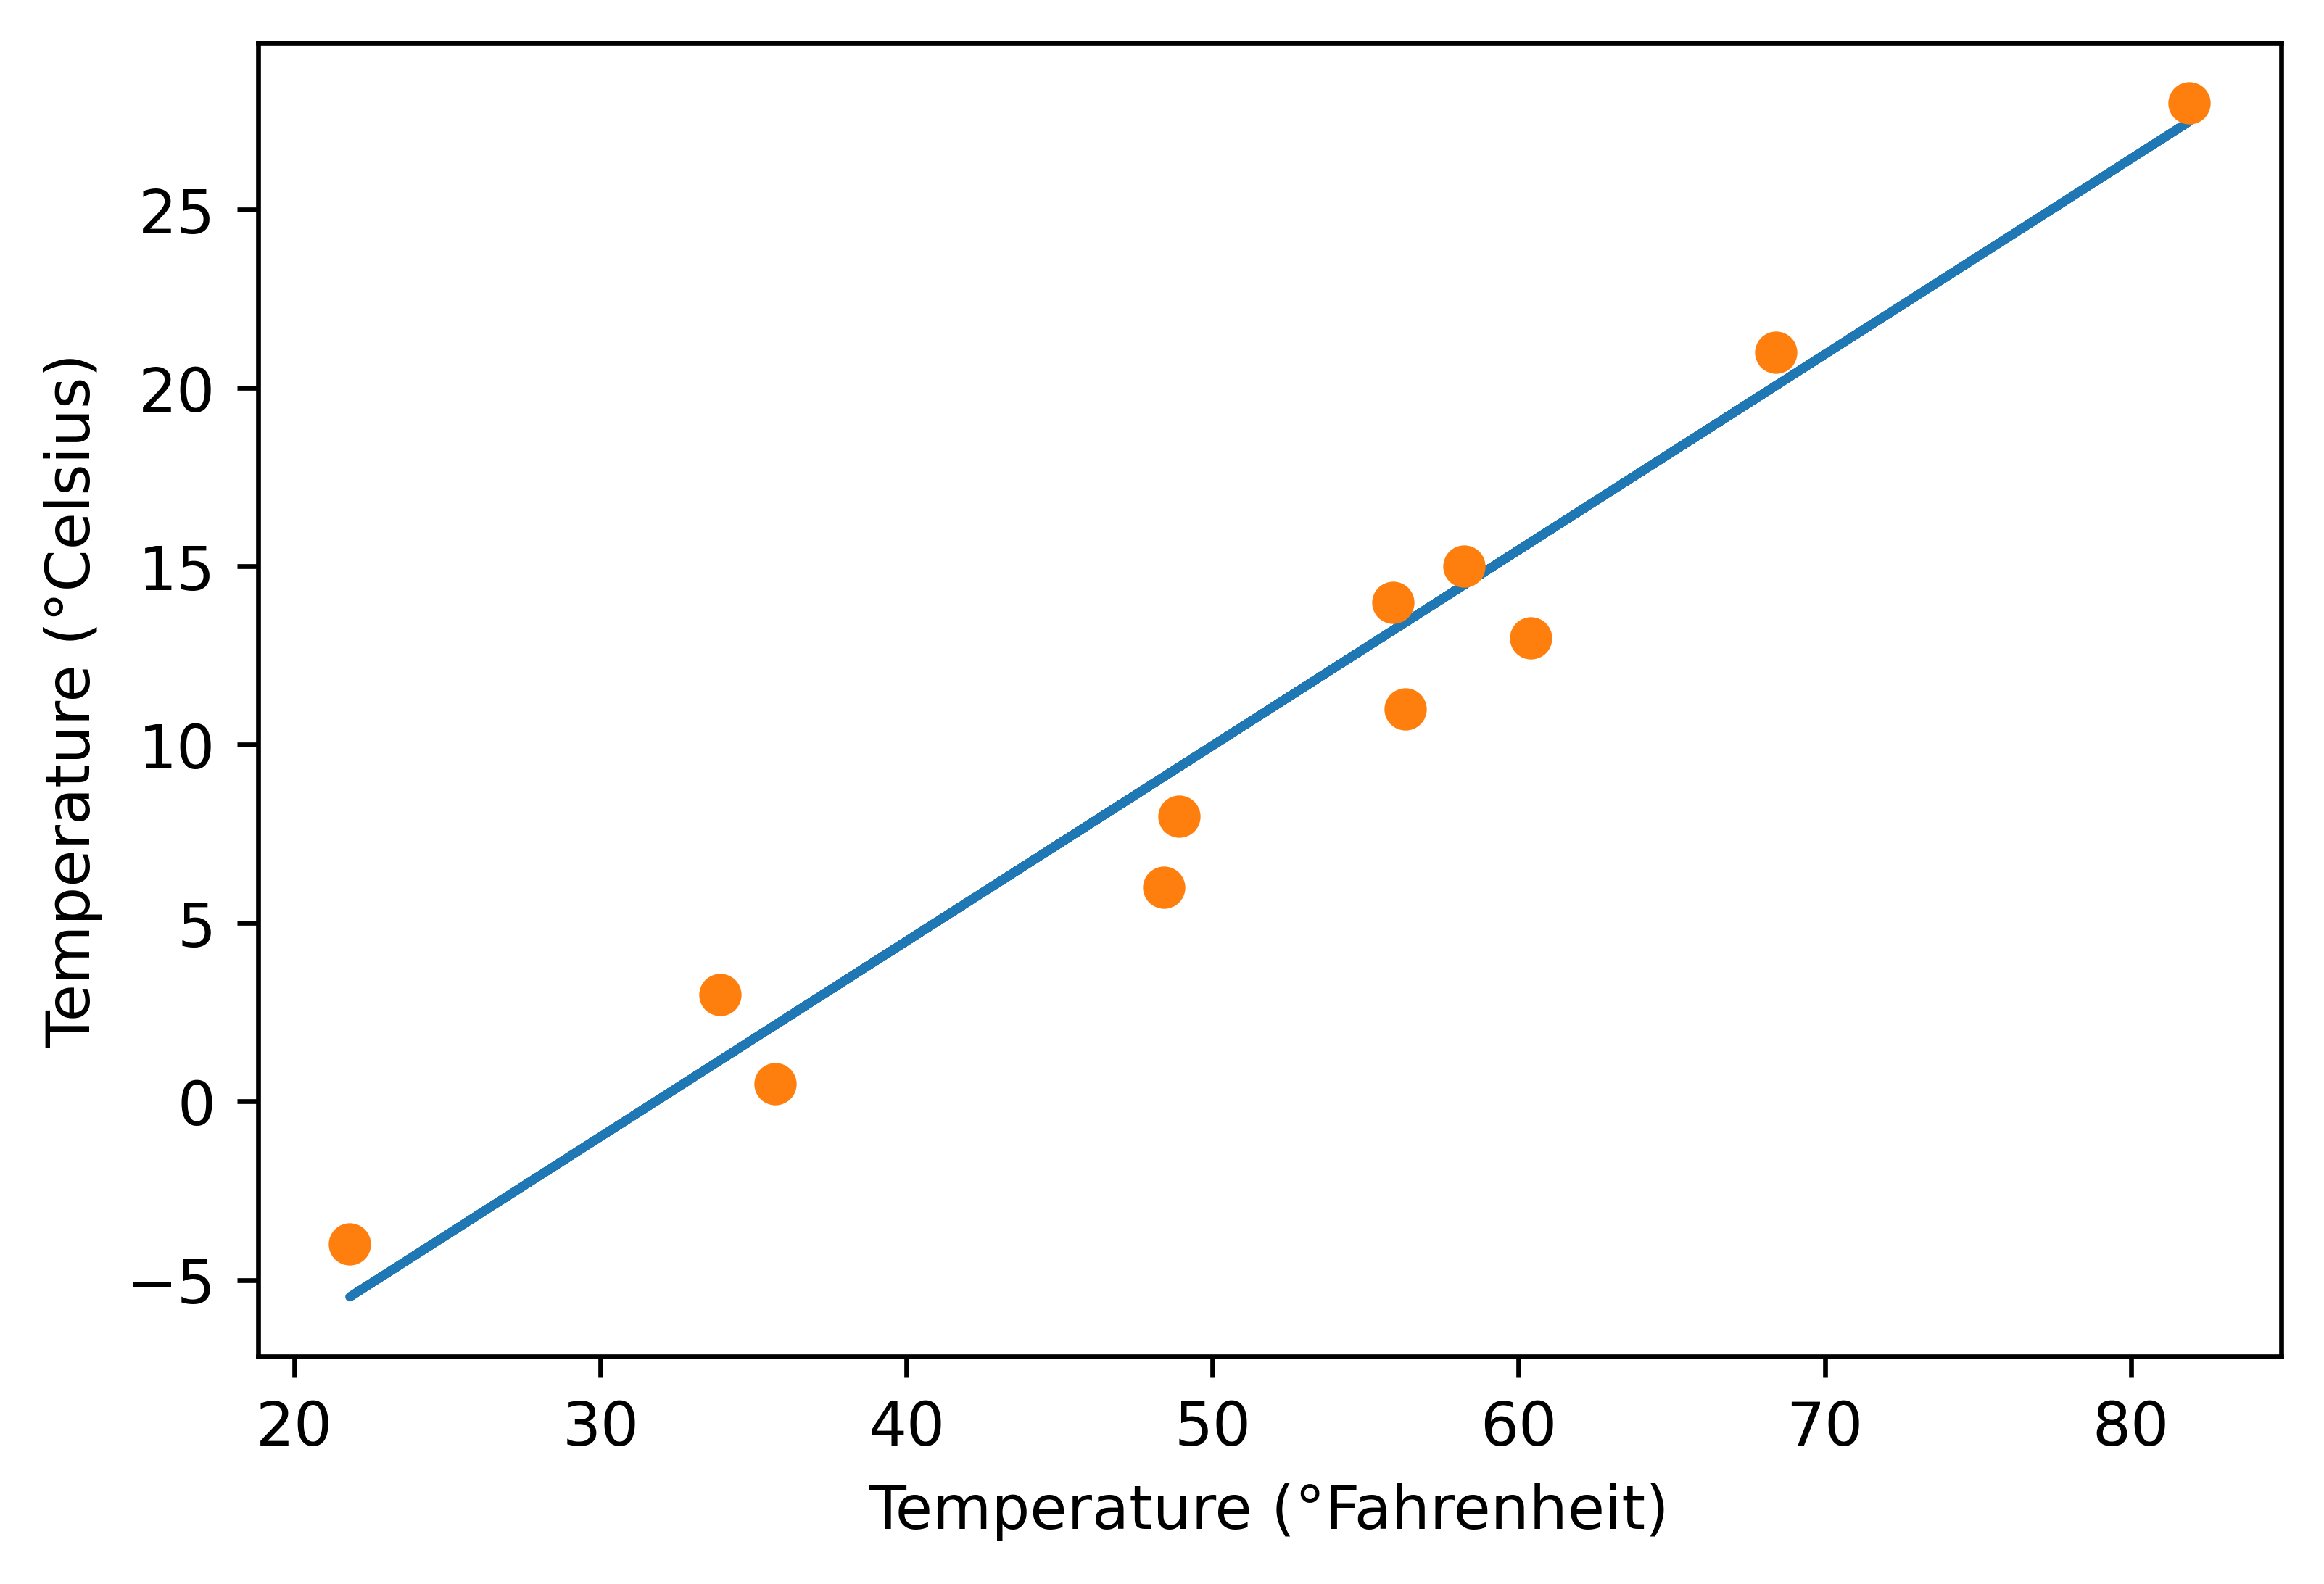
2. 비선형 모델 model2 학습 결과
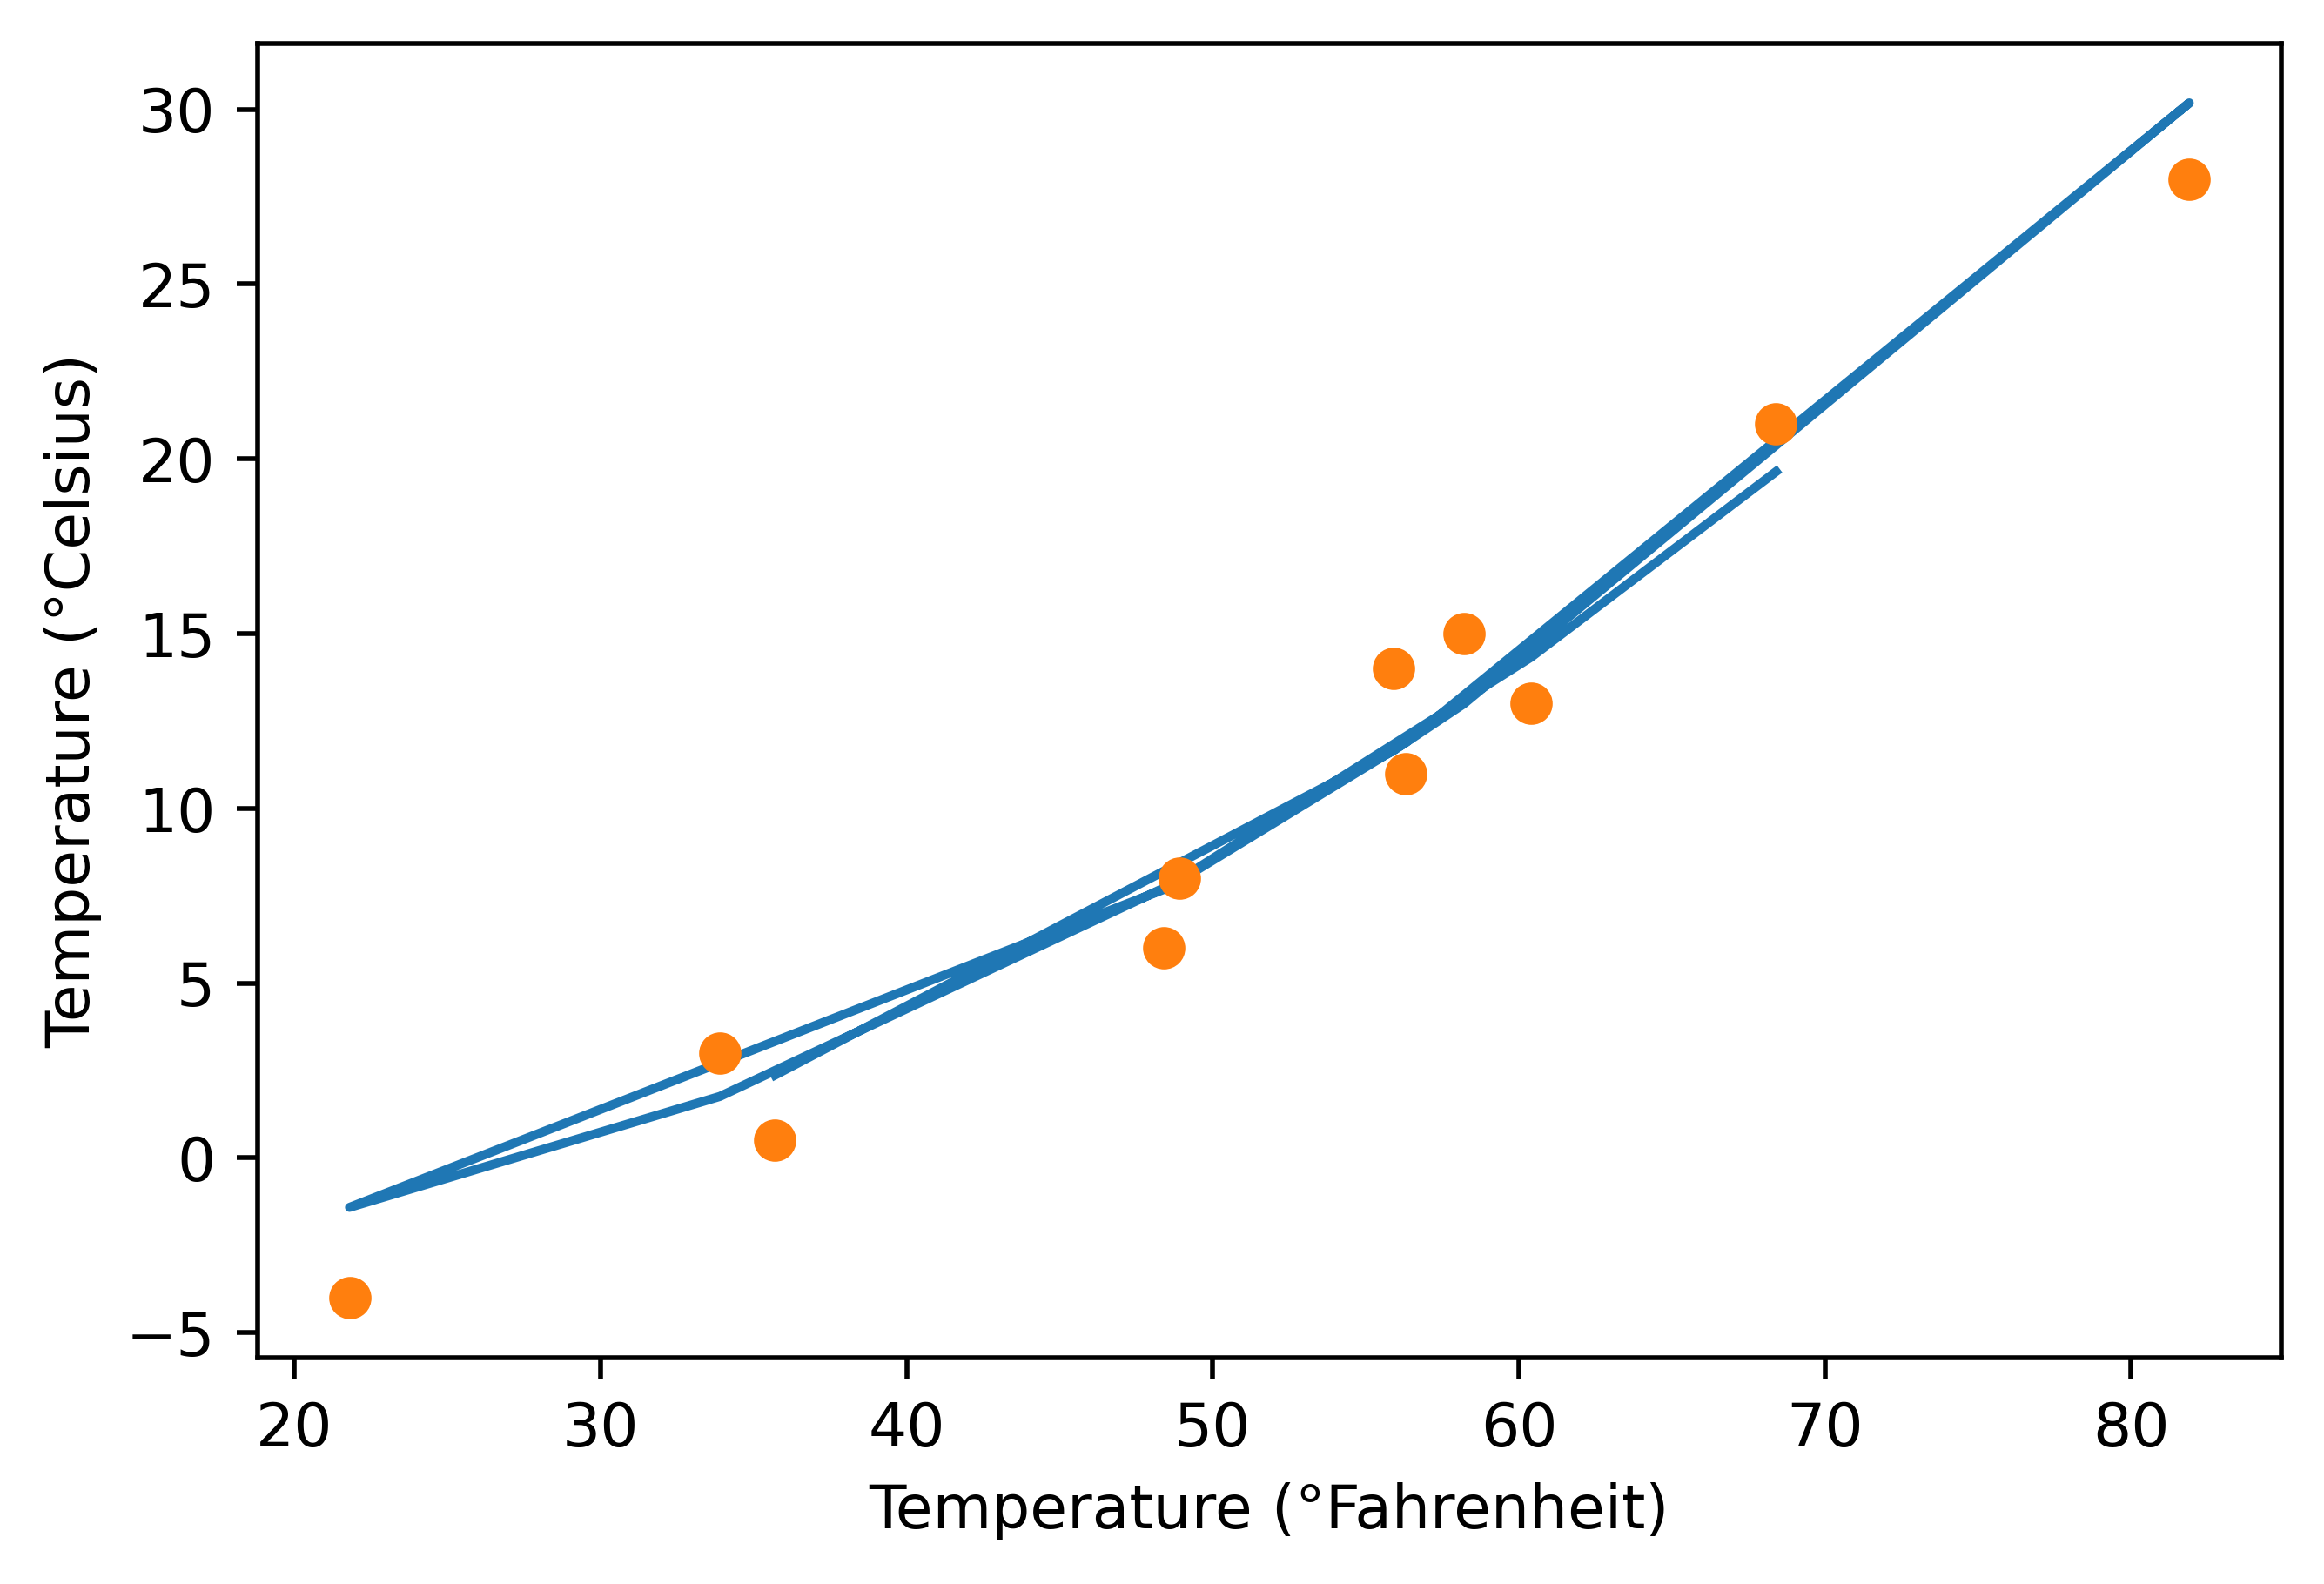
 과제로 주어진 비선형 모델의 구현은 학습 데이터, 검증데이터 모두에 대한 오류가 쉽게 잡히지 않았다. 따라서 선형회귀 모델보다 학습 반복수를 크게 줘야 오류가 잡혔다. 또한 그래프로 그렸을 때, 비선형 모델이 특정 데이터 값들에 대한 오차가 선형모델보다 큰 것을 확인했다. 
